In [12]:
%run setup.ipynb
%run ../gwss/setup.ipynb
%run peak-utils.ipynb 

In [48]:
@numba.njit(nogil=True)
def pair_diffs(x, y):
    n = x.shape[0]
    d = 0
    for i in range(n):
        d += (x[i] != y[i])
    return d
    

@numba.njit(nogil=True)
def pairwise_diffs_between(h1, h2):
    n1 = h1.shape[1]
    n2 = h2.shape[1]
    out = np.empty((n1, n2), dtype=np.int32)
    for i in range(n1):
        for j in range(n2):
            out[i, j] = pair_diffs(h1[:, i], h2[:, j])
    return out.flatten()


In [49]:
h1 = np.array([[0, 0, 1], [1, 0, 0]])
h2 = np.array([[0, 1, 1], [1, 1, 1]])
pairwise_diffs_between(h1, h2)

array([0, 1, 1, 1, 2, 2, 2, 1, 1], dtype=int32)

In [34]:
df_haps_a.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [35]:
df_haps_x.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [17]:
import dask

In [87]:
bphh_root = zarr.open(str(here() / 'data/gwss/bphh/bphh.zarr'))

In [104]:
def run_bphh(pop1, pop2, chromosome, window_size, n=50, seed=42, threshold=1):
    np.random.seed(seed)

    # avoid running the same scan twice
    pop1, pop2 = sorted([pop1, pop2])

    # setup zarr group to store data
    grp_path = f'/{pop1}_{pop2}_{chromosome}_{window_size}_{n}_{seed}_{threshold}'
    grp = bphh_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)

    if complete:
        # previously run, load from zarr
        windows = grp['windows'][:]
        gwindows = grp['gwindows'][:]
        bphh = grp['bphh'][:]

    else:
        
        print('loading haplotypes')
        if chromosome == 'X':
            pos = callset_haps[chromosome]['variants/POS'][:]
            ht = allel.GenotypeDaskArray(callset_haps[chromosome]['calldata/GT']).to_haplotypes().values

            # locate haplotypes for populations
            loc_pop1 = df_haps_x.query(pop_defs[pop1]['query']).index.values
            if len(loc_pop1) > n:
                loc_pop1 = sorted(np.random.choice(loc_pop1, size=n, replace=False))
            loc_pop2 = df_haps_x.query(pop_defs[pop2]['query']).index.values
            if len(loc_pop2) > n:
                loc_pop2 = sorted(np.random.choice(loc_pop2, size=n, replace=False))
            ht_pop1 = da.take(ht, loc_pop1, axis=1).compute()
            ht_pop2 = da.take(ht, loc_pop2, axis=1).compute()

        else:

            # concatenate data from both arms
            # remember, right arm goes on the left
            arm_r = f'{chromosome}R'
            arm_l = f'{chromosome}L'
            pos_r = callset_haps[arm_r]['variants/POS'][:]
            pos_l = callset_haps[arm_l]['variants/POS'][:]
            pos = np.concatenate([pos_r, pos_l + len(genome[arm_r])])
            ht_r = allel.GenotypeDaskArray(callset_haps[arm_r]['calldata/GT']).to_haplotypes().values
            ht_l = allel.GenotypeDaskArray(callset_haps[arm_l]['calldata/GT']).to_haplotypes().values
            ht = da.concatenate([ht_r, ht_l], axis=0)

            # locate haplotypes for populations
            loc_pop1 = df_haps_a.query(pop_defs[pop1]['query']).index.values
            if len(loc_pop1) > n:
                loc_pop1 = sorted(np.random.choice(loc_pop1, size=n, replace=False))
            loc_pop2 = df_haps_a.query(pop_defs[pop2]['query']).index.values
            if len(loc_pop2) > n:
                loc_pop2 = sorted(np.random.choice(loc_pop2, size=n, replace=False))
            ht_pop1 = da.take(ht, loc_pop1, axis=1).compute()
            ht_pop2 = da.take(ht, loc_pop2, axis=1).compute()

        # perform the scan
        print('running scan')
        gpos = np.take(gmap[chromosome], pos-1)
        windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_size)
        gwindows = allel.moving_statistic(gpos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_size)
        ix_windows = list(allel.stats.window.index_windows(ht, size=window_size, step=window_size, start=0, stop=None))
    #     result = np.array([
    #         pairwise_diffs_between(ht_pop1[i:j], ht_pop2[i:j])
    #         for i, j in ix_windows
    #     ], dtype=int)
        delayed_f = dask.delayed(pairwise_diffs_between)
        result, = dask.compute([
            delayed_f(ht_pop1[i:j], ht_pop2[i:j])
            for i, j in ix_windows
        ])
        result = np.array(result)
        bphh = (result <= threshold).sum(axis=1) / result.shape[1]

        # store results
        grp.create_dataset('windows', data=windows, overwrite=True)
        grp.create_dataset('gwindows', data=gwindows, overwrite=True)
        grp.create_dataset('bphh', data=bphh, overwrite=True)
        grp.attrs['complete'] = True

    return windows, gwindows, bphh
    

In [105]:
pops = sorted(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [ ]:
for pop1, pop2 in itertools.combinations(pops, 2):
    for chromosome in '23X':
        for window_size in 1000, 2000:
            print(pop1, pop2, chromosome, window_size)
            %time run_bphh(pop1, pop2, chromosome, window_size=window_size, n=50);

ao_col bf_col 2 1000
CPU times: user 2.63 ms, sys: 52 µs, total: 2.68 ms
Wall time: 1.85 ms
ao_col bf_col 2 2000
loading haplotypes
running scan
CPU times: user 5min 58s, sys: 3.85 s, total: 6min 2s
Wall time: 26.3 s
ao_col bf_col 3 1000
CPU times: user 1.2 ms, sys: 23 µs, total: 1.23 ms
Wall time: 1.18 ms
ao_col bf_col 3 2000
loading haplotypes
running scan


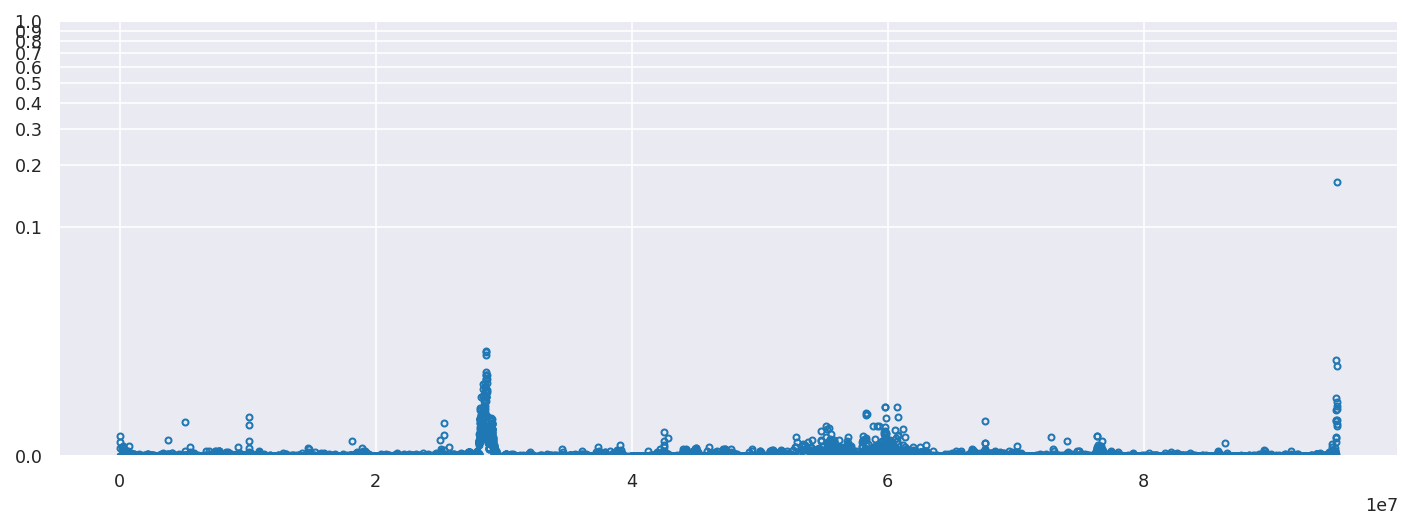

In [99]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(w.mean(axis=1), bphh, linestyle=' ', marker='o', mfc='none', markersize=3)
ax.set_ylim(0, 1)
ax.set_yscale('symlog', linthresh=0.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1f}"));